# Лабораторная работа №8. Generation

In [2]:
from __future__ import annotations

import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as IPImage, display

In [3]:
data_dir = Path("done_dataset_pokemon")
output_dir = Path("outputs")
output_dir.mkdir(parents=True, exist_ok=True)

image_size = 48
batch_size = 64
latent_dim = 128
num_epochs = 60
learning_rate = 1e-3
num_workers = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed)
torch.manual_seed(seed)


In [4]:
class ImageFolderFlat(Dataset):
    def __init__(self, root: Path, transform=None):
        self.root = Path(root)
        self.files = sorted([p for p in self.root.glob("*.png")])
        if not self.files:
            raise FileNotFoundError(f"No .png files found in {self.root}")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # [-1, 1]
    ]
)

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

dataset = ImageFolderFlat(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

print("Samples:", len(dataset))


Samples: 1024


Saved: outputs\real_grid.png


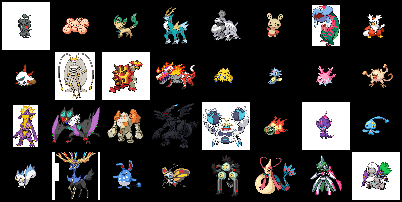

In [5]:
real_batch = next(iter(dataloader))
grid = utils.make_grid(denorm(real_batch[:32]), nrow=8)
utils.save_image(grid, output_dir / "real_grid.png")
print("Saved:", output_dir / "real_grid.png")
display(IPImage(filename=str(output_dir / "real_grid.png")))


In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 3, image_size, image_size)
            enc_dim = self.encoder(dummy).shape[1]

        self.fc_mu = nn.Linear(enc_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, enc_dim)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, image_size // 16, image_size // 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h = self.encoder(x)
        z = self.fc_mu(h)
        return z

    def decode(self, z):
        h = self.fc_dec(z)
        x = self.decoder(h)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z


model = AutoEncoder(latent_dim=latent_dim).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [7]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total = 0.0
    for batch in loader:
        batch = batch.to(device)
        recon, _ = model(batch)
        loss = loss_fn(recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item() * batch.size(0)
    return total / len(loader.dataset)


loss_history = []
for epoch in range(1, num_epochs + 1):
    avg_loss = train_one_epoch(model, dataloader, optimizer, loss_fn, device)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch:02d} | L1 loss: {avg_loss:.4f}")


Epoch 01 | L1 loss: 0.6056
Epoch 02 | L1 loss: 0.2791
Epoch 03 | L1 loss: 0.2084
Epoch 04 | L1 loss: 0.1759
Epoch 05 | L1 loss: 0.1614
Epoch 06 | L1 loss: 0.1583
Epoch 07 | L1 loss: 0.1520
Epoch 08 | L1 loss: 0.1477
Epoch 09 | L1 loss: 0.1463
Epoch 10 | L1 loss: 0.1452
Epoch 11 | L1 loss: 0.1374
Epoch 12 | L1 loss: 0.1367
Epoch 13 | L1 loss: 0.1344
Epoch 14 | L1 loss: 0.1293
Epoch 15 | L1 loss: 0.1270
Epoch 16 | L1 loss: 0.1285
Epoch 17 | L1 loss: 0.1255
Epoch 18 | L1 loss: 0.1230
Epoch 19 | L1 loss: 0.1236
Epoch 20 | L1 loss: 0.1202
Epoch 21 | L1 loss: 0.1212
Epoch 22 | L1 loss: 0.1226
Epoch 23 | L1 loss: 0.1188
Epoch 24 | L1 loss: 0.1168
Epoch 25 | L1 loss: 0.1144
Epoch 26 | L1 loss: 0.1147
Epoch 27 | L1 loss: 0.1155
Epoch 28 | L1 loss: 0.1128
Epoch 29 | L1 loss: 0.1126
Epoch 30 | L1 loss: 0.1117
Epoch 31 | L1 loss: 0.1110
Epoch 32 | L1 loss: 0.1097
Epoch 33 | L1 loss: 0.1068
Epoch 34 | L1 loss: 0.1075
Epoch 35 | L1 loss: 0.1063
Epoch 36 | L1 loss: 0.1047
Epoch 37 | L1 loss: 0.1036
E

Saved: outputs\loss_curve.png


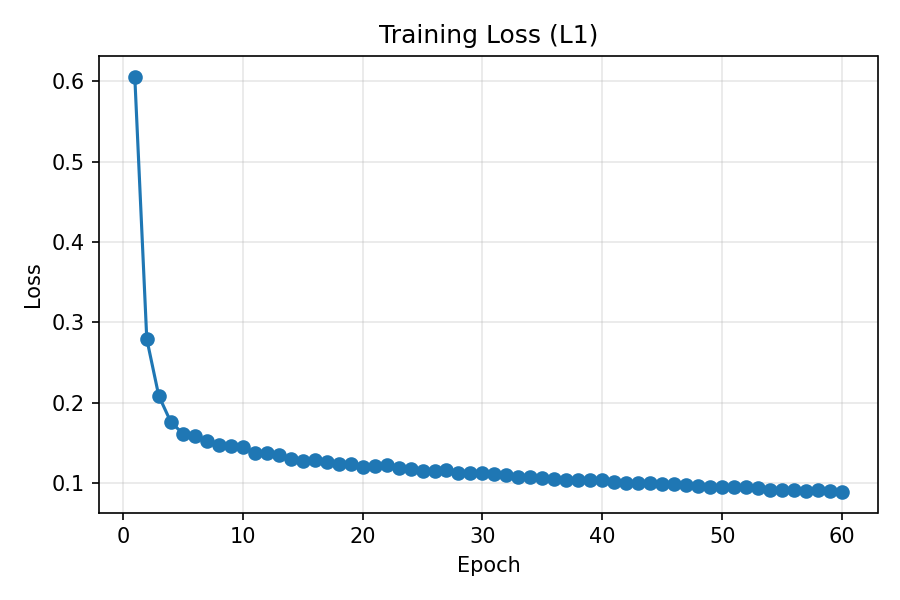

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker="o")
plt.title("Training Loss (L1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
loss_plot_path = output_dir / "loss_curve.png"
plt.tight_layout()
plt.savefig(loss_plot_path, dpi=150)
plt.close()
print("Saved:", loss_plot_path)
display(IPImage(filename=str(loss_plot_path)))

Saved: outputs\reconstructions.png


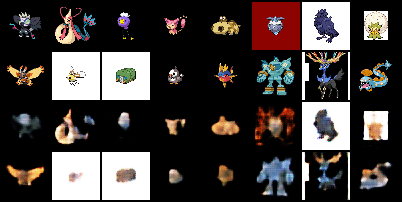

In [9]:
# Reconstructions: originals vs reconstructions
model.eval()
with torch.no_grad():
    batch = next(iter(dataloader))[:16].to(device)
    recon, _ = model(batch)
    comparison = torch.cat([denorm(batch.cpu()), denorm(recon.cpu())], dim=0)
    grid = utils.make_grid(comparison, nrow=8)
    recon_path = output_dir / "reconstructions.png"
    utils.save_image(grid, recon_path)
print("Saved:", recon_path)
display(IPImage(filename=str(recon_path)))


Saved: outputs\generated_grid.png


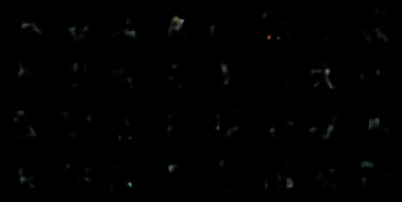

In [10]:
# Generate samples from random latent vectors
model.eval()
with torch.no_grad():
    z = torch.randn(32, latent_dim, device=device)
    samples = model.decode(z).cpu()
    grid = utils.make_grid(denorm(samples), nrow=8)
    utils.save_image(grid, output_dir / "generated_grid.png")
print("Saved:", output_dir / "generated_grid.png")
display(IPImage(filename=str(output_dir / "generated_grid.png")))


Saved: outputs\latent_interpolation.gif


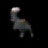

In [11]:
# Latent space interpolation GIF
import imageio.v2 as imageio

model.eval()
with torch.no_grad():
    idx_a, idx_b = random.sample(range(len(dataset)), 2)
    img_a = dataset[idx_a].unsqueeze(0).to(device)
    img_b = dataset[idx_b].unsqueeze(0).to(device)

    z_a = model.encode(img_a)
    z_b = model.encode(img_b)

    steps = 30
    frames = []
    for t in torch.linspace(0.0, 1.0, steps):
        z_t = (1 - t) * z_a + t * z_b
        gen = model.decode(z_t).cpu()
        img = denorm(gen).squeeze(0).permute(1, 2, 0).numpy()
        frame = (img * 255).astype("uint8")
        frames.append(frame)

gif_path = output_dir / "latent_interpolation.gif"
imageio.mimsave(gif_path, frames, fps=10)
print("Saved:", gif_path)
display(IPImage(filename=str(gif_path)))
